# experiments on image transformation

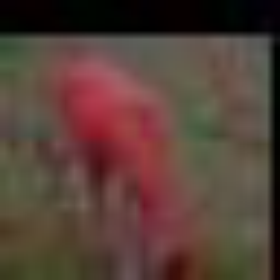

In [636]:
# import requierd libraries
import torch
from PIL import Image
import torchvision.transforms as transforms

# Read the input image
img = Image.open('train/113.jpg')
transform = transforms.Resize(280)
transform(img)


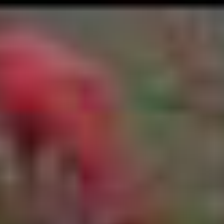

In [656]:

# define the transform to apply random affine
transform = transforms.Compose([
                          transforms.RandomResizedCrop(280,scale=(0.8,1.2)),
                          transforms.CenterCrop(224),
                          transforms.RandomHorizontalFlip()])

# apply the above defined transform on the input image
transform(img)

# display the transformed image
#img

# prepare

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import pandas as pd
from sklearn.model_selection import train_test_split
import PIL
import os
from IPython.display import Image 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
data = pd.read_csv("train_labels.csv")

In [3]:
train_df, val_df = train_test_split(data, test_size=0.2, random_state=1,stratify=data["label"])

In [4]:
train_df

,id,label
38897,38897,7
24035,24035,2
27492,27492,9
5994,5994,4
14389,14389,6
...,...,...
46328,46328,5
14888,14888,9
45597,45597,0
10841,10841,1


In [5]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [6]:
train_df

,id,label
0,38897,7
1,24035,2
2,27492,9
3,5994,4
4,14389,6
...,...,...
39995,46328,5
39996,14888,9
39997,45597,0
39998,10841,1


In [22]:
data_transformers = {"train": transforms.Compose([
                                       transforms.RandomResizedCrop(32),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                             [0.229,0.224,0.225])]),
            "val":transforms.Compose([transforms.Resize(34),
                          transforms.CenterCrop(32),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485,0.456,0.406],
                                     [0.229,0.224,0.225])])}

In [31]:
data_transformers2 = {"train": transforms.Compose([transforms.RandomResizedCrop(280,scale=(0.8,1.2)),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                             [0.229,0.224,0.225])]),
            "val":transforms.Compose([transforms.Resize(256),
                          transforms.CenterCrop(224),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485,0.456,0.406],
                                     [0.229,0.224,0.225])])}

In [23]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_df, images_folder, transform=None):
        self.df = csv_df
        self.image_folder = images_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df["id"][index]
        label = self.df["label"][index]
        image = PIL.Image.open(self.image_folder+str(filename)+".jpg")
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [24]:
train_data = CustomDataset(train_df, "./train/",transform=data_transformers["train"])
val_data = CustomDataset(val_df, "./train/", transform=data_transformers["val"])

In [25]:
train_loader = DataLoader(train_data, batch_size=128,shuffle=True)
val_loader = DataLoader(val_data, batch_size =128, shuffle=True)

In [40]:
def accuracy_test(model,dataloader,epoch):
    correct = 0
    total = 0
    model.cuda() 
    model.eval()
    total_loss = 0
    with torch.no_grad(): 
        for data in dataloader:
           
            images,labels = data
            images,labels = images.to('cuda'),labels.to('cuda')
            

            outputs = model(images)
            _, predicted = torch.max(outputs.data,1) 
            loss = criterion(outputs,labels)
            total_loss += loss.item()
            
            
            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()
            
    print("The validation loss is %.4f" % (total_loss/len(dataloader)))
    print('The valudation accuracy is {:.4f}\n'.format(correct/total))

from tqdm.auto import tqdm
import math

def train(model,trainloader,epochs,print_every,criterion,optimizer,device,name):
    num_training_steps = epochs * (len(trainloader))
    progress_bar = tqdm(range(num_training_steps))
    epochs = epochs 
    print_every = math.floor(num_training_steps/print_every)
    steps = 0
    model.to(device)
    model.train()
    total = 0
    correct = 0

    name = name
    running_loss = 0
    for e in range(epochs):
        #running_loss = 0
        for ii , (inputs,labels) in enumerate(trainloader):
            steps += 1
            inputs,labels = inputs.to(device),labels.to(device)
            optimizer.zero_grad() 
            
            # 前馈及反馈
            outputs = model(inputs) 
            
            _, predicted = torch.max(outputs.data,1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            #print(labels.size(),outputs.size())
            loss = criterion(outputs,labels) 
            loss.backward() 
            optimizer.step() 
            
            running_loss += loss.item() # maybe accumulate loss for steps?
            progress_bar.update(1)
            
            if steps % print_every == 0:
                #test the accuracy
                print('EPOCHS : {}/{}'.format(e+1,epochs),
                      'Loss : {:.6f}'.format(running_loss/print_every)) # this is a simgle loss divided by print_every
                print('The training accuracy is {:.4f}'.format(correct/total))
                running_loss=0
                accuracy_test(model,val_loader,e)
                #print("training accuracy: \n")
                #accuracy_test(model,trainloader)
        torch.save(model.state_dict(), "Weights/myVGGv2-size32-_{}.pkl".format(name + "Epoch"+str(e+1)))

# self-defined model #1 - test accuracy 70%

In [15]:
# implementing VGG model from scratch
class myVGG(nn.Module):
    def __init__(self):
        super(myVGG,self).__init__()
        self.conv11=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.batch11 = nn.BatchNorm2d(64)
        self.conv12=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.batch12 = nn.BatchNorm2d(64)
        self.conv21=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.batch21 = nn.BatchNorm2d(128)
        self.conv22=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.dropout2=nn.Dropout2d(p=0.2)
        self.conv31=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.conv41=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.dense1=nn.Linear(in_features=8192,out_features=64)
        self.dropout3=nn.Dropout(p=0.5)
        self.dense2=nn.Linear(in_features=64,out_features=10)
    
    def forward(self,x):

        x = self.conv11(x)
        x = self.batch11(x)
        x = self.conv12(x)
        x = self.batch12(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.conv21(x)
        x = self.batch21(x)
        x = self.conv22(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = F.max_pool2d(x,2)
        x = self.conv31(x)
        x = F.relu(x)
        #x = F.max_pool2d(x,2)
        x = self.conv41(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        #print(x.shape)
        x = torch.flatten(x,1)
        #print(x.shape)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dropout3(x)
        output = self.dense2(x)
        return output

In [16]:
myVGG = myVGG()
myVGG.cuda()
print(myVGG)

myVGG(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense1): Linear(in_features=8192, out_features=64, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=64, out_features=10, bias=True)
)


In [17]:
criterion = nn.CrossEntropyLoss().cuda()

In [17]:
optimizer = optim.AdamW(myVGG.parameters(),lr=1e-4)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-1-')

  0%|          | 0/3750 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 1.977239
The training accuracy is 0.2722
The valudation accuracy is 0.4078

EPOCHS : 1/6 Loss : 1.544935
The training accuracy is 0.3558
The valudation accuracy is 0.4542

EPOCHS : 1/6 Loss : 1.473530
The training accuracy is 0.3913
The valudation accuracy is 0.4859

EPOCHS : 1/6 Loss : 1.411070
The training accuracy is 0.4158
The valudation accuracy is 0.4994

EPOCHS : 1/6 Loss : 1.358819
The training accuracy is 0.4365
The valudation accuracy is 0.5158

EPOCHS : 1/6 Loss : 1.304288
The training accuracy is 0.4537
The valudation accuracy is 0.5349

EPOCHS : 2/6 Loss : 1.260490
The training accuracy is 0.4680
The valudation accuracy is 0.5568

EPOCHS : 2/6 Loss : 1.179377
The training accuracy is 0.4819
The valudation accuracy is 0.5816

EPOCHS : 2/6 Loss : 1.134709
The training accuracy is 0.4950
The valudation accuracy is 0.5980

EPOCHS : 2/6 Loss : 1.114957
The training accuracy is 0.5068
The valudation accuracy is 0.6157

EPOCHS : 2/6 Loss : 1.079205
The trainin

In [18]:
optimizer = optim.AdamW(myVGG.parameters(),lr=8e-5)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-2-')

  0%|          | 0/3750 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 0.876782
The training accuracy is 0.6991
The valudation accuracy is 0.7782

EPOCHS : 1/6 Loss : 0.476093
The training accuracy is 0.7723
The valudation accuracy is 0.7956

EPOCHS : 1/6 Loss : 0.432037
The training accuracy is 0.8006
The valudation accuracy is 0.7957

EPOCHS : 1/6 Loss : 0.425270
The training accuracy is 0.8133
The valudation accuracy is 0.8108

EPOCHS : 1/6 Loss : 0.400934
The training accuracy is 0.8232
The valudation accuracy is 0.8023

EPOCHS : 1/6 Loss : 0.374807
The training accuracy is 0.8314
The valudation accuracy is 0.8165

EPOCHS : 2/6 Loss : 0.363930
The training accuracy is 0.8380
The valudation accuracy is 0.8107

EPOCHS : 2/6 Loss : 0.313928
The training accuracy is 0.8448
The valudation accuracy is 0.8145

EPOCHS : 2/6 Loss : 0.312120
The training accuracy is 0.8507
The valudation accuracy is 0.8123

EPOCHS : 2/6 Loss : 0.324369
The training accuracy is 0.8546
The valudation accuracy is 0.8105

EPOCHS : 2/6 Loss : 0.323168
The trainin

# retrain with Avacyn's transformation size=224

In [16]:
# retrain
optimizer = optim.AdamW(myVGG.parameters(),lr=1e-4)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-1-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.050248
The training accuracy is 0.2574
The validation loss is 1.8568
The valudation accuracy is 0.3523

EPOCHS : 1/6 Loss : 1.816845
The training accuracy is 0.3019
The validation loss is 1.7249
The valudation accuracy is 0.3872

EPOCHS : 1/6 Loss : 1.764052
The training accuracy is 0.3236
The validation loss is 1.5938
The valudation accuracy is 0.4426

EPOCHS : 1/6 Loss : 1.736061
The training accuracy is 0.3377
The validation loss is 1.5862
The valudation accuracy is 0.4484

EPOCHS : 1/6 Loss : 1.690177
The training accuracy is 0.3506
The validation loss is 1.4958
The valudation accuracy is 0.4755

EPOCHS : 1/6 Loss : 1.641873
The training accuracy is 0.3613
The validation loss is 1.4821
The valudation accuracy is 0.4831

EPOCHS : 2/6 Loss : 1.609845
The training accuracy is 0.3712
The validation loss is 1.4695
The valudation accuracy is 0.4730

EPOCHS : 2/6 Loss : 1.604310
The training accuracy is 0.3782
The validation loss is 1.4278
The valudation accuracy is 

# retrain with Avacyn's transformation size = 112

In [15]:
# reduce final layer from 512 to 256, num parameters 100352 --> 50176 (reduce size) --> 25088 (reduce filter map) (12544?)
#  first dropout 0.1 --> 0.3 second 0.3 --> 0.5
optimizer = optim.AdamW(myVGG.parameters(),lr=5e-5)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-1-')

  0%|          | 0/3750 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.166491
The training accuracy is 0.1956
The validation loss is 2.0222
The valudation accuracy is 0.3018

EPOCHS : 1/6 Loss : 1.884212
The training accuracy is 0.2594
The validation loss is 1.7954
The valudation accuracy is 0.3473

EPOCHS : 1/6 Loss : 1.774636
The training accuracy is 0.2921
The validation loss is 1.7926
The valudation accuracy is 0.3500

EPOCHS : 1/6 Loss : 1.768765
The training accuracy is 0.3095
The validation loss is 1.7495
The valudation accuracy is 0.3655

EPOCHS : 1/6 Loss : 1.729580
The training accuracy is 0.3234
The validation loss is 1.7027
The valudation accuracy is 0.3773

EPOCHS : 1/6 Loss : 1.689478
The training accuracy is 0.3354
The validation loss is 1.6882
The valudation accuracy is 0.3928

EPOCHS : 2/6 Loss : 1.690769
The training accuracy is 0.3441
The validation loss is 1.6820
The valudation accuracy is 0.3957

EPOCHS : 2/6 Loss : 1.648935
The training accuracy is 0.3524
The validation loss is 1.6897
The valudation accuracy is 

KeyboardInterrupt: 

In [16]:
# further reduce size to 84, change final conv layer to 512 filters
#  in_features = 12544 * 2 / 2 * 1.5 = 18816 (12800?)
optimizer = optim.AdamW(myVGG.parameters(),lr=1e-4)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-1-')

  0%|          | 0/1878 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.181258
The training accuracy is 0.1902
The validation loss is 1.9730
The valudation accuracy is 0.3095

EPOCHS : 1/6 Loss : 1.870561
The training accuracy is 0.2597
The validation loss is 1.7969
The valudation accuracy is 0.3597

EPOCHS : 1/6 Loss : 1.776035
The training accuracy is 0.2913
The validation loss is 1.6492
The valudation accuracy is 0.4081

EPOCHS : 1/6 Loss : 1.731838
The training accuracy is 0.3116
The validation loss is 1.5869
The valudation accuracy is 0.4266

EPOCHS : 1/6 Loss : 1.702675
The training accuracy is 0.3258
The validation loss is 1.5401
The valudation accuracy is 0.4468

EPOCHS : 1/6 Loss : 1.673314
The training accuracy is 0.3384
The validation loss is 1.5210
The valudation accuracy is 0.4562

EPOCHS : 2/6 Loss : 1.648010
The training accuracy is 0.3487
The validation loss is 1.4774
The valudation accuracy is 0.4788

EPOCHS : 2/6 Loss : 1.626739
The training accuracy is 0.3584
The validation loss is 1.4988
The valudation accuracy is 

KeyboardInterrupt: 

In [39]:
optimizer = optim.AdamW(myVGG.parameters(),lr=1e-4)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-1-')

  0%|          | 0/3750 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.137380
The training accuracy is 0.2025
The validation loss is 1.9104
The valudation accuracy is 0.3096

EPOCHS : 1/6 Loss : 1.841927
The training accuracy is 0.2648
The validation loss is 1.7179
The valudation accuracy is 0.3907

EPOCHS : 1/6 Loss : 1.748619
The training accuracy is 0.3037
The validation loss is 1.6584
The valudation accuracy is 0.3965

EPOCHS : 1/6 Loss : 1.681016
The training accuracy is 0.3272
The validation loss is 1.5818
The valudation accuracy is 0.4415

EPOCHS : 1/6 Loss : 1.648646
The training accuracy is 0.3436
The validation loss is 1.5095
The valudation accuracy is 0.4687

EPOCHS : 1/6 Loss : 1.625671
The training accuracy is 0.3558
The validation loss is 1.4680
The valudation accuracy is 0.4875

EPOCHS : 2/6 Loss : 1.567699
The training accuracy is 0.3680
The validation loss is 1.4607
The valudation accuracy is 0.4883

EPOCHS : 2/6 Loss : 1.567995
The training accuracy is 0.3781
The validation loss is 1.3465
The valudation accuracy is 

In [40]:
optimizer = optim.AdamW(myVGG.parameters(),lr=1e-5)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-2-')

  0%|          | 0/3750 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 1.635198
The training accuracy is 0.4165
The validation loss is 1.0340
The valudation accuracy is 0.7292

EPOCHS : 1/6 Loss : 1.138590
The training accuracy is 0.5271
The validation loss is 0.8017
The valudation accuracy is 0.7414

EPOCHS : 1/6 Loss : 1.007949
The training accuracy is 0.5722
The validation loss is 0.7635
The valudation accuracy is 0.7452

EPOCHS : 1/6 Loss : 1.004586
The training accuracy is 0.5933
The validation loss is 0.7358
The valudation accuracy is 0.7531

EPOCHS : 1/6 Loss : 0.978114
The training accuracy is 0.6059
The validation loss is 0.7148
The valudation accuracy is 0.7559

EPOCHS : 1/6 Loss : 0.976819
The training accuracy is 0.6165
The validation loss is 0.7119
The valudation accuracy is 0.7571

EPOCHS : 2/6 Loss : 0.972833
The training accuracy is 0.6235
The validation loss is 0.6991
The valudation accuracy is 0.7587

EPOCHS : 2/6 Loss : 0.943506
The training accuracy is 0.6293
The validation loss is 0.6971
The valudation accuracy is 

KeyboardInterrupt: 

In [ ]:
# try a much simpler architecture (25600)
optimizer = optim.AdamW(myVGG.parameters(),lr=1e-4)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-sim1-')

  0%|          | 0/3750 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.082586
The training accuracy is 0.2334
The validation loss is 1.8748
The valudation accuracy is 0.3534

EPOCHS : 1/6 Loss : 1.801351
The training accuracy is 0.2895
The validation loss is 1.6552
The valudation accuracy is 0.4110

EPOCHS : 1/6 Loss : 1.738664
The training accuracy is 0.3218
The validation loss is 1.5929
The valudation accuracy is 0.4251

EPOCHS : 1/6 Loss : 1.671414
The training accuracy is 0.3429
The validation loss is 1.4889
The valudation accuracy is 0.4754

EPOCHS : 1/6 Loss : 1.675684
The training accuracy is 0.3552
The validation loss is 1.4650
The valudation accuracy is 0.4941

EPOCHS : 1/6 Loss : 1.591821
The training accuracy is 0.3677
The validation loss is 1.4995
The valudation accuracy is 0.4643

EPOCHS : 2/6 Loss : 1.605480
The training accuracy is 0.3765
The validation loss is 1.4159
The valudation accuracy is 0.5077

EPOCHS : 2/6 Loss : 1.581408
The training accuracy is 0.3838
The validation loss is 1.4070
The valudation accuracy is 

# Retrain size = 32

In [18]:
# 6 convolutional layers and 3 max pooling
optimizer = optim.AdamW(myVGG.parameters(),lr=1e-4)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-32-1-')

  0%|          | 0/1878 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.189520
The training accuracy is 0.1763
The validation loss is 2.0104
The valudation accuracy is 0.2983

EPOCHS : 1/6 Loss : 1.899775
The training accuracy is 0.2476
The validation loss is 1.7316
The valudation accuracy is 0.3683

EPOCHS : 1/6 Loss : 1.757219
The training accuracy is 0.2856
The validation loss is 1.7004
The valudation accuracy is 0.3866

EPOCHS : 1/6 Loss : 1.706372
The training accuracy is 0.3111
The validation loss is 1.5510
The valudation accuracy is 0.4592

EPOCHS : 1/6 Loss : 1.672329
The training accuracy is 0.3288
The validation loss is 1.5275
The valudation accuracy is 0.4492

EPOCHS : 1/6 Loss : 1.618945
The training accuracy is 0.3441
The validation loss is 1.5269
The valudation accuracy is 0.4662

EPOCHS : 2/6 Loss : 1.608347
The training accuracy is 0.3554
The validation loss is 1.4962
The valudation accuracy is 0.4778

EPOCHS : 2/6 Loss : 1.565083
The training accuracy is 0.3665
The validation loss is 1.3980
The valudation accuracy is 

In [19]:
optimizer = optim.AdamW(myVGG.parameters(),lr=1e-5)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-32-2-')

  0%|          | 0/1878 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 1.797214
The training accuracy is 0.3697
The validation loss is 1.2093
The valudation accuracy is 0.6790

EPOCHS : 1/6 Loss : 1.275045
The training accuracy is 0.4841
The validation loss is 0.9795
The valudation accuracy is 0.6862

EPOCHS : 1/6 Loss : 1.140437
The training accuracy is 0.5279
The validation loss is 0.9114
The valudation accuracy is 0.6989

EPOCHS : 1/6 Loss : 1.118047
The training accuracy is 0.5478
The validation loss is 0.8779
The valudation accuracy is 0.7034

EPOCHS : 1/6 Loss : 1.105881
The training accuracy is 0.5606
The validation loss is 0.8647
The valudation accuracy is 0.7068

EPOCHS : 1/6 Loss : 1.108709
The training accuracy is 0.5694
The validation loss is 0.8582
The valudation accuracy is 0.7088

EPOCHS : 2/6 Loss : 1.084521
The training accuracy is 0.5780
The validation loss is 0.8442
The valudation accuracy is 0.7099

EPOCHS : 2/6 Loss : 1.079794
The training accuracy is 0.5843
The validation loss is 0.8379
The valudation accuracy is 

In [20]:
optimizer = optim.AdamW(myVGG.parameters(),lr=1e-6)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-32-3-')

  0%|          | 0/1878 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.309337
The training accuracy is 0.3212
The validation loss is 0.9495
The valudation accuracy is 0.6723

EPOCHS : 1/6 Loss : 1.189719
The training accuracy is 0.4575
The validation loss is 0.8449
The valudation accuracy is 0.7246

EPOCHS : 1/6 Loss : 1.113575
The training accuracy is 0.5135
The validation loss is 0.8212
The valudation accuracy is 0.7312

EPOCHS : 1/6 Loss : 1.070350
The training accuracy is 0.5465
The validation loss is 0.8184
The valudation accuracy is 0.7312

EPOCHS : 1/6 Loss : 1.059814
The training accuracy is 0.5661
The validation loss is 0.8164
The valudation accuracy is 0.7330

EPOCHS : 1/6 Loss : 1.064052
The training accuracy is 0.5777
The validation loss is 0.8064
The valudation accuracy is 0.7341

EPOCHS : 2/6 Loss : 1.052475
The training accuracy is 0.5878
The validation loss is 0.8032
The valudation accuracy is 0.7346

EPOCHS : 2/6 Loss : 1.033104
The training accuracy is 0.5955
The validation loss is 0.7991
The valudation accuracy is 

# self-define model #2

In [13]:
class myVGG16(nn.Module):
    def __init__(self):
        super(myVGG16,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.3),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.5),
            
            
            
        )
        self.finalconv = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.finaldense = nn.Sequential(
            nn.Linear(25088,2048,True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048,1024,True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        x = self.finalconv(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [14]:
myVGG16 = myVGG16()
print(myVGG16)

myVGG16(
  (convlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.2, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

In [15]:
criterion = nn.CrossEntropyLoss().cuda()

In [29]:
optimizer = optim.AdamW(myVGG16.parameters(),lr=5e-5)
train(myVGG16,train_loader,3,20,criterion,optimizer,'cuda','-1-')

  0%|          | 0/3750 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 2.178841
The training accuracy is 0.1676
The validation loss is 1.9412
The valudation accuracy is 0.2935

EPOCHS : 1/3 Loss : 1.873047
The training accuracy is 0.2443
The validation loss is 1.7347
The valudation accuracy is 0.3829

EPOCHS : 1/3 Loss : 1.713815
The training accuracy is 0.2933
The validation loss is 1.6505
The valudation accuracy is 0.4062

EPOCHS : 1/3 Loss : 1.640478
The training accuracy is 0.3244
The validation loss is 1.5823
The valudation accuracy is 0.4348

EPOCHS : 1/3 Loss : 1.552145
The training accuracy is 0.3493
The validation loss is 1.5039
The valudation accuracy is 0.4640

EPOCHS : 1/3 Loss : 1.502034
The training accuracy is 0.3697
The validation loss is 1.4269
The valudation accuracy is 0.4910

EPOCHS : 2/3 Loss : 1.437607
The training accuracy is 0.3873
The validation loss is 1.3836
The valudation accuracy is 0.5051

EPOCHS : 2/3 Loss : 1.414099
The training accuracy is 0.4011
The validation loss is 1.3685
The valudation accuracy is 

In [16]:
myVGG16.load_state_dict(torch.load("Weights/myVGG16_-1-Epoch3.pkl"))

<All keys matched successfully>

In [17]:
optimizer = optim.AdamW(myVGG16.parameters(),lr=5e-6)
train(myVGG16,train_loader,3,20,criterion,optimizer,'cuda','-2-')

  0%|          | 0/3750 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.295028
The training accuracy is 0.5526
The validation loss is 0.9694
The valudation accuracy is 0.6593

EPOCHS : 1/3 Loss : 0.887511
The training accuracy is 0.6215
The validation loss is 0.9131
The valudation accuracy is 0.6745

EPOCHS : 1/3 Loss : 0.865350
The training accuracy is 0.6442
The validation loss is 0.8870
The valudation accuracy is 0.6838

EPOCHS : 1/3 Loss : 0.826370
The training accuracy is 0.6605
The validation loss is 0.8703
The valudation accuracy is 0.6868

EPOCHS : 1/3 Loss : 0.835204
The training accuracy is 0.6687
The validation loss is 0.8647
The valudation accuracy is 0.6896

EPOCHS : 1/3 Loss : 0.802876
The training accuracy is 0.6750
The validation loss is 0.8644
The valudation accuracy is 0.6895

EPOCHS : 2/3 Loss : 0.814852
The training accuracy is 0.6807
The validation loss is 0.8633
The valudation accuracy is 0.6932

EPOCHS : 2/3 Loss : 0.787687
The training accuracy is 0.6859
The validation loss is 0.8483
The valudation accuracy is 

In [18]:
optimizer = optim.AdamW(myVGG16.parameters(),lr=2e-7)
train(myVGG16,train_loader,3,20,criterion,optimizer,'cuda','-3-')

  0%|          | 0/3750 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.262174
The training accuracy is 0.5675
The validation loss is 0.8712
The valudation accuracy is 0.6930

EPOCHS : 1/3 Loss : 0.757418
The training accuracy is 0.6546
The validation loss is 0.8431
The valudation accuracy is 0.7040

EPOCHS : 1/3 Loss : 0.736012
The training accuracy is 0.6863
The validation loss is 0.8284
The valudation accuracy is 0.7095

EPOCHS : 1/3 Loss : 0.725736
The training accuracy is 0.7028
The validation loss is 0.8195
The valudation accuracy is 0.7119

EPOCHS : 1/3 Loss : 0.718315
The training accuracy is 0.7121
The validation loss is 0.8144
The valudation accuracy is 0.7134

EPOCHS : 1/3 Loss : 0.701568
The training accuracy is 0.7195
The validation loss is 0.8082
The valudation accuracy is 0.7137

EPOCHS : 2/3 Loss : 0.703507
The training accuracy is 0.7245
The validation loss is 0.8040
The valudation accuracy is 0.7140

EPOCHS : 2/3 Loss : 0.696495
The training accuracy is 0.7288
The validation loss is 0.8005
The valudation accuracy is 

In [27]:
class myVGG16v2(nn.Module):
    def __init__(self):
        super(myVGG16v2,self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(2,2)
            
            
            
        )
        self.finaldense = nn.Sequential(
            nn.Linear(8192,256,True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256,64,True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64,10,True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        x = torch.flatten(x,1)
        x = self.finaldense(x)
        return x

In [28]:
myVGG16 = myVGG16v2()
print(myVGG16)

myVGG16v2(
  (convlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.2, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Conv2d(256,

In [17]:
criterion = nn.CrossEntropyLoss().cuda()

In [18]:
optimizer = optim.AdamW(myVGG16.parameters(),lr=8e-5)
train(myVGG16,train_loader,3,20,criterion,optimizer,'cuda','-1-')

  0%|          | 0/5625 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 2.131327
The training accuracy is 0.2135
The validation loss is 1.8885
The valudation accuracy is 0.3044

EPOCHS : 1/3 Loss : 1.844497
The training accuracy is 0.2691
The validation loss is 1.7317
The valudation accuracy is 0.3735

EPOCHS : 1/3 Loss : 1.731647
The training accuracy is 0.3063
The validation loss is 1.6700
The valudation accuracy is 0.3962

EPOCHS : 1/3 Loss : 1.643181
The training accuracy is 0.3334
The validation loss is 1.5979
The valudation accuracy is 0.4224

EPOCHS : 1/3 Loss : 1.590234
The training accuracy is 0.3549
The validation loss is 1.5298
The valudation accuracy is 0.4535

EPOCHS : 1/3 Loss : 1.519894
The training accuracy is 0.3743
The validation loss is 1.4681
The valudation accuracy is 0.4718

EPOCHS : 2/3 Loss : 1.460251
The training accuracy is 0.3893
The validation loss is 1.4285
The valudation accuracy is 0.4950

EPOCHS : 2/3 Loss : 1.438143
The training accuracy is 0.4032
The validation loss is 1.4576
The valudation accuracy is 

In [19]:
optimizer = optim.AdamW(myVGG16.parameters(),lr=2e-5)
train(myVGG16,train_loader,3,20,criterion,optimizer,'cuda','-2-')

  0%|          | 0/5625 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.333426
The training accuracy is 0.5278
The validation loss is 1.0429
The valudation accuracy is 0.6408

EPOCHS : 1/3 Loss : 0.892988
The training accuracy is 0.6091
The validation loss is 0.9665
The valudation accuracy is 0.6633

EPOCHS : 1/3 Loss : 0.871469
The training accuracy is 0.6346
The validation loss is 0.9688
The valudation accuracy is 0.6642

EPOCHS : 1/3 Loss : 0.837691
The training accuracy is 0.6506
The validation loss is 0.9489
The valudation accuracy is 0.6666

EPOCHS : 1/3 Loss : 0.855724
The training accuracy is 0.6606
The validation loss is 0.9425
The valudation accuracy is 0.6708

EPOCHS : 1/3 Loss : 0.830387
The training accuracy is 0.6674
The validation loss is 0.9230
The valudation accuracy is 0.6785

EPOCHS : 2/3 Loss : 0.804724
The training accuracy is 0.6746
The validation loss is 0.9037
The valudation accuracy is 0.6856

EPOCHS : 2/3 Loss : 0.763382
The training accuracy is 0.6827
The validation loss is 0.8964
The valudation accuracy is 

In [20]:
optimizer = optim.AdamW(myVGG16.parameters(),lr=9e-6)
train(myVGG16,train_loader,3,20,criterion,optimizer,'cuda','-3-')

  0%|          | 0/5625 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.261951
The training accuracy is 0.5587
The validation loss is 0.8670
The valudation accuracy is 0.7125

EPOCHS : 1/3 Loss : 0.640892
The training accuracy is 0.6715
The validation loss is 0.8106
The valudation accuracy is 0.7148

EPOCHS : 1/3 Loss : 0.602571
The training accuracy is 0.7081
The validation loss is 0.8087
The valudation accuracy is 0.7250

EPOCHS : 1/3 Loss : 0.630756
The training accuracy is 0.7263
The validation loss is 0.7999
The valudation accuracy is 0.7278

EPOCHS : 1/3 Loss : 0.560567
The training accuracy is 0.7426
The validation loss is 0.8082
The valudation accuracy is 0.7240

EPOCHS : 1/3 Loss : 0.609712
The training accuracy is 0.7501
The validation loss is 0.7941
The valudation accuracy is 0.7254

EPOCHS : 2/3 Loss : 0.581205
The training accuracy is 0.7567
The validation loss is 0.7907
The valudation accuracy is 0.7276

EPOCHS : 2/3 Loss : 0.542983
The training accuracy is 0.7643
The validation loss is 0.8061
The valudation accuracy is 

KeyboardInterrupt: 

# retrain size=32

In [29]:
optimizer = optim.AdamW(myVGG16.parameters(),lr=5e-5)
train(myVGG16,train_loader,6,40,criterion,optimizer,'cuda','-32-1-')

  0%|          | 0/1878 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.289709
The training accuracy is 0.1180
The validation loss is 2.1864
The valudation accuracy is 0.2099

EPOCHS : 1/6 Loss : 2.060213
The training accuracy is 0.1746
The validation loss is 1.9279
The valudation accuracy is 0.2985

EPOCHS : 1/6 Loss : 1.937520
The training accuracy is 0.2104
The validation loss is 1.8732
The valudation accuracy is 0.3180

EPOCHS : 1/6 Loss : 1.860249
The training accuracy is 0.2351
The validation loss is 1.7802
The valudation accuracy is 0.3469

EPOCHS : 1/6 Loss : 1.851388
The training accuracy is 0.2499
The validation loss is 1.8463
The valudation accuracy is 0.2992

EPOCHS : 1/6 Loss : 1.794693
The training accuracy is 0.2657
The validation loss is 1.6997
The valudation accuracy is 0.3777

EPOCHS : 2/6 Loss : 1.753010
The training accuracy is 0.2781
The validation loss is 1.6526
The valudation accuracy is 0.4003

EPOCHS : 2/6 Loss : 1.706619
The training accuracy is 0.2906
The validation loss is 1.6265
The valudation accuracy is 

In [30]:
optimizer = optim.AdamW(myVGG16.parameters(),lr=1e-6)
train(myVGG16,train_loader,6,40,criterion,optimizer,'cuda','-32-2-')

  0%|          | 0/1878 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 5.848756
The training accuracy is 0.2269
The validation loss is 2.3208
The valudation accuracy is 0.4418

EPOCHS : 1/6 Loss : 2.275179
The training accuracy is 0.3243
The validation loss is 1.4993
The valudation accuracy is 0.5168

EPOCHS : 1/6 Loss : 1.733789
The training accuracy is 0.3704
The validation loss is 1.3039
The valudation accuracy is 0.5456

EPOCHS : 1/6 Loss : 1.577491
The training accuracy is 0.3975
The validation loss is 1.2270
The valudation accuracy is 0.5582

EPOCHS : 1/6 Loss : 1.480011
The training accuracy is 0.4174
The validation loss is 1.1904
The valudation accuracy is 0.5693

EPOCHS : 1/6 Loss : 1.469160
The training accuracy is 0.4285
The validation loss is 1.1643
The valudation accuracy is 0.5773

EPOCHS : 2/6 Loss : 1.449624
The training accuracy is 0.4383
The validation loss is 1.1533
The valudation accuracy is 0.5801

EPOCHS : 2/6 Loss : 1.384975
The training accuracy is 0.4474
The validation loss is 1.1510
The valudation accuracy is 

In [31]:
optimizer = optim.AdamW(myVGG16.parameters(),lr=1e-6)
train(myVGG16,train_loader,6,40,criterion,optimizer,'cuda','-32-3-')

  0%|          | 0/1878 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 3.889069
The training accuracy is 0.2315
The validation loss is 1.3670
The valudation accuracy is 0.5164

EPOCHS : 1/6 Loss : 1.457418
The training accuracy is 0.3586
The validation loss is 1.1221
The valudation accuracy is 0.5902

EPOCHS : 1/6 Loss : 1.342839
The training accuracy is 0.4112
The validation loss is 1.1075
The valudation accuracy is 0.5953

EPOCHS : 1/6 Loss : 1.325973
The training accuracy is 0.4407
The validation loss is 1.1030
The valudation accuracy is 0.5980

EPOCHS : 1/6 Loss : 1.328368
The training accuracy is 0.4573
The validation loss is 1.1136
The valudation accuracy is 0.5970

EPOCHS : 1/6 Loss : 1.299026
The training accuracy is 0.4697
The validation loss is 1.1047
The valudation accuracy is 0.5971

EPOCHS : 2/6 Loss : 1.319596
The training accuracy is 0.4774
The validation loss is 1.1083
The valudation accuracy is 0.5984

EPOCHS : 2/6 Loss : 1.324131
The training accuracy is 0.4839
The validation loss is 1.1098
The valudation accuracy is 

KeyboardInterrupt: 

In [32]:
optimizer = optim.AdamW(myVGG16.parameters(),lr=1e-8)
train(myVGG16,train_loader,6,40,criterion,optimizer,'cuda','-32-4-')

  0%|          | 0/1878 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 3.561097
The training accuracy is 0.2155
The validation loss is 1.2103
The valudation accuracy is 0.5580

EPOCHS : 1/6 Loss : 1.463117
The training accuracy is 0.3483
The validation loss is 1.1978
The valudation accuracy is 0.5592

EPOCHS : 1/6 Loss : 1.447020
The training accuracy is 0.3973
The validation loss is 1.1995
The valudation accuracy is 0.5622

EPOCHS : 1/6 Loss : 1.452954
The training accuracy is 0.4192
The validation loss is 1.1922
The valudation accuracy is 0.5635

EPOCHS : 1/6 Loss : 1.429716
The training accuracy is 0.4345


KeyboardInterrupt: 

# even simpler model

In [36]:
# implementing VGG model from scratch
class myVGGv2(nn.Module):
    def __init__(self):
        super(myVGGv2,self).__init__()
        self.conv11=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.batch11 = nn.BatchNorm2d(64)
        self.conv12=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.batch12 = nn.BatchNorm2d(64)
        self.conv21=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.batch21 = nn.BatchNorm2d(128)
        self.conv22=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.dropout2=nn.Dropout2d(p=0.2)
        self.conv31=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.conv41=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.dense1=nn.Linear(in_features=8192,out_features=64)
        self.dropout3=nn.Dropout(p=0.5)
        self.dense2=nn.Linear(in_features=64,out_features=10)
    
    def forward(self,x):

        x = self.conv11(x)
        x = self.batch11(x)
        x = self.conv12(x)
        x = self.batch12(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.conv21(x)
        x = self.batch21(x)
        #x = self.conv22(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = F.max_pool2d(x,2)
        x = self.conv31(x)
        x = F.relu(x)
        #x = F.max_pool2d(x,2)
        x = self.conv41(x)
        x = F.relu(x)
        #x = F.max_pool2d(x,2)
        #print(x.shape)
        x = torch.flatten(x,1)
        #print(x.shape)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dropout3(x)
        output = self.dense2(x)
        return output

In [37]:
myVGG = myVGGv2()
print(myVGG)

myVGGv2(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense1): Linear(in_features=8192, out_features=64, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=64, out_features=10, bias=True)
)


In [41]:
# 
optimizer = optim.AdamW(myVGG.parameters(),lr=1e-4)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-32-2-1-')

  0%|          | 0/1878 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.184422
The training accuracy is 0.2007
The validation loss is 2.0193
The valudation accuracy is 0.3149

EPOCHS : 1/6 Loss : 1.898511
The training accuracy is 0.2593
The validation loss is 1.7818
The valudation accuracy is 0.3641

EPOCHS : 1/6 Loss : 1.794445
The training accuracy is 0.2891
The validation loss is 1.6079
The valudation accuracy is 0.4335

EPOCHS : 1/6 Loss : 1.715465
The training accuracy is 0.3143
The validation loss is 1.5919
The valudation accuracy is 0.4380

EPOCHS : 1/6 Loss : 1.665943
The training accuracy is 0.3329
The validation loss is 1.5327
The valudation accuracy is 0.4523

EPOCHS : 1/6 Loss : 1.638721
The training accuracy is 0.3472
The validation loss is 1.5080
The valudation accuracy is 0.4733

EPOCHS : 2/6 Loss : 1.633481
The training accuracy is 0.3571
The validation loss is 1.4323
The valudation accuracy is 0.4962

EPOCHS : 2/6 Loss : 1.594396
The training accuracy is 0.3657
The validation loss is 1.4095
The valudation accuracy is 

In [39]:
optimizer = optim.AdamW(myVGG.parameters(),lr=1e-6)
train(myVGG,train_loader,6,40,criterion,optimizer,'cuda','-32-2-2-')

  0%|          | 0/1878 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.632237
The training accuracy is 0.3123
The validation loss is 0.9465
The valudation accuracy is 0.6683



KeyboardInterrupt: 

# VGG16 - test accuracy 75%

In [13]:
VGG16 = models.vgg16(pretrained=False)
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
VGG16.classifier[6] = nn.Linear(in_features=4096,out_features=10,bias=True)

In [15]:
criterion = nn.CrossEntropyLoss().cuda()

In [28]:
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.AdamW(VGG16.parameters(),lr=1e-4)

In [32]:
train(VGG16,train_loader,3,40,criterion,optimizer,'cuda','-data-0204-VGG-1')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.005834
the accuracy is 0.3400
EPOCHS : 1/3 Loss : 0.004645
the accuracy is 0.3891
EPOCHS : 1/3 Loss : 0.005584
the accuracy is 0.3882
EPOCHS : 1/3 Loss : 0.005011
the accuracy is 0.4210
EPOCHS : 1/3 Loss : 0.004541
the accuracy is 0.4320
EPOCHS : 1/3 Loss : 0.004931
the accuracy is 0.4439


KeyboardInterrupt: 

In [34]:
torch.save(VGG16.state_dict(), "Weights/Mannual-VGG16-0")

In [17]:
VGG16.load_state_dict(torch.load("Weights/Epoch_2-data-0204-VGG-1.pkl"))

<All keys matched successfully>

In [18]:
optimizer = optim.AdamW(VGG16.parameters(),lr=5e-5)
train(VGG16,train_loader,3,40,criterion,optimizer,'cuda','-data-0204-VGG-1')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.004601
the accuracy is 0.4787
EPOCHS : 1/3 Loss : 0.003249
the accuracy is 0.4990
EPOCHS : 1/3 Loss : 0.003743
the accuracy is 0.4989
EPOCHS : 1/3 Loss : 0.004872
the accuracy is 0.5096


KeyboardInterrupt: 

In [20]:
torch.save(VGG16.state_dict(), "Weights/Mannual-VGG16-1")

In [16]:
VGG16.load_state_dict(torch.load("Weights/Mannual-VGG16-1"))

<All keys matched successfully>

In [17]:
optimizer = optim.AdamW(VGG16.parameters(),lr=1e-5)
train(VGG16,train_loader,3,40,criterion,optimizer,'cuda','-data-0204-VGG-1')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.004236
the accuracy is 0.5323
EPOCHS : 1/3 Loss : 0.003602
the accuracy is 0.5401
EPOCHS : 1/3 Loss : 0.004164
the accuracy is 0.5462
EPOCHS : 1/3 Loss : 0.003352
the accuracy is 0.5479
EPOCHS : 1/3 Loss : 0.003665
the accuracy is 0.5510
EPOCHS : 1/3 Loss : 0.002344
the accuracy is 0.5544
EPOCHS : 2/3 Loss : 0.003521
the accuracy is 0.5549
EPOCHS : 2/3 Loss : 0.004184
the accuracy is 0.5576
EPOCHS : 2/3 Loss : 0.003697
the accuracy is 0.5628
EPOCHS : 2/3 Loss : 0.004529
the accuracy is 0.5601
EPOCHS : 2/3 Loss : 0.003338
the accuracy is 0.5751
EPOCHS : 2/3 Loss : 0.004096
the accuracy is 0.5783
EPOCHS : 2/3 Loss : 0.003161
the accuracy is 0.5818
EPOCHS : 3/3 Loss : 0.003611
the accuracy is 0.5862
EPOCHS : 3/3 Loss : 0.004410
the accuracy is 0.5817
EPOCHS : 3/3 Loss : 0.003466
the accuracy is 0.5722
EPOCHS : 3/3 Loss : 0.005404
the accuracy is 0.5908
EPOCHS : 3/3 Loss : 0.003113
the accuracy is 0.5794
EPOCHS : 3/3 Loss : 0.003843
the accuracy is 0.5819
EPOCHS : 3/3

In [19]:
# train with lower lr
optimizer = optim.AdamW(VGG16.parameters(),lr=5e-6)
train(VGG16,train_loader,3,40,criterion,optimizer,'cuda','-2-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.003781
the accuracy is 0.6001
EPOCHS : 1/3 Loss : 0.003959
the accuracy is 0.6019
EPOCHS : 1/3 Loss : 0.002679
the accuracy is 0.6017
EPOCHS : 1/3 Loss : 0.004247
the accuracy is 0.6053
EPOCHS : 1/3 Loss : 0.003257
the accuracy is 0.6035
EPOCHS : 1/3 Loss : 0.002851
the accuracy is 0.6046
EPOCHS : 2/3 Loss : 0.003243
the accuracy is 0.6102
EPOCHS : 2/3 Loss : 0.003287
the accuracy is 0.6098
EPOCHS : 2/3 Loss : 0.003625
the accuracy is 0.6133
EPOCHS : 2/3 Loss : 0.003955
the accuracy is 0.6144
EPOCHS : 2/3 Loss : 0.003528
the accuracy is 0.6161
EPOCHS : 2/3 Loss : 0.002736
the accuracy is 0.6151
EPOCHS : 2/3 Loss : 0.003950
the accuracy is 0.6181
EPOCHS : 3/3 Loss : 0.003117
the accuracy is 0.6163


KeyboardInterrupt: 

In [ ]:
VGG16.load_state_dict(torch.load("Weights/Mannual-VGG16-1"))

In [18]:
# train with higher lr
optimizer = optim.AdamW(VGG16.parameters(),lr=1e-5)
train(VGG16,train_loader,3,40,criterion,optimizer,'cuda','-2-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.003605
the accuracy is 0.5969
EPOCHS : 1/3 Loss : 0.003682
the accuracy is 0.6014
EPOCHS : 1/3 Loss : 0.005338
the accuracy is 0.5920
EPOCHS : 1/3 Loss : 0.002751
the accuracy is 0.6008
EPOCHS : 1/3 Loss : 0.001958
the accuracy is 0.5929
EPOCHS : 1/3 Loss : 0.002020
the accuracy is 0.6135
EPOCHS : 2/3 Loss : 0.002635
the accuracy is 0.6038
EPOCHS : 2/3 Loss : 0.003466
the accuracy is 0.6140
EPOCHS : 2/3 Loss : 0.004513
the accuracy is 0.6116
EPOCHS : 2/3 Loss : 0.004307
the accuracy is 0.6146
EPOCHS : 2/3 Loss : 0.003673
the accuracy is 0.6195
EPOCHS : 2/3 Loss : 0.003955
the accuracy is 0.6156
EPOCHS : 2/3 Loss : 0.002689
the accuracy is 0.6142


KeyboardInterrupt: 

In [16]:
VGG16.load_state_dict(torch.load("Weights/VGG_-2-Epoch0.pkl"))

<All keys matched successfully>

In [17]:
# train with higher lr
optimizer = optim.AdamW(VGG16.parameters(),lr=5e-5)
train(VGG16,train_loader,3,40,criterion,optimizer,'cuda','-2-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.003977
the accuracy is 0.5829
EPOCHS : 1/3 Loss : 0.003449
the accuracy is 0.5655
EPOCHS : 1/3 Loss : 0.004262
the accuracy is 0.5567
EPOCHS : 1/3 Loss : 0.002875
the accuracy is 0.5826
EPOCHS : 1/3 Loss : 0.004321
the accuracy is 0.5668
EPOCHS : 1/3 Loss : 0.002312
the accuracy is 0.6123
EPOCHS : 2/3 Loss : 0.003770
the accuracy is 0.5829
EPOCHS : 2/3 Loss : 0.002856
the accuracy is 0.5981
EPOCHS : 2/3 Loss : 0.004422
the accuracy is 0.6129
EPOCHS : 2/3 Loss : 0.003143
the accuracy is 0.6074
EPOCHS : 2/3 Loss : 0.003105
the accuracy is 0.6197
EPOCHS : 2/3 Loss : 0.003315
the accuracy is 0.6250
EPOCHS : 2/3 Loss : 0.003076
the accuracy is 0.6211
EPOCHS : 3/3 Loss : 0.003059
the accuracy is 0.6156
EPOCHS : 3/3 Loss : 0.004858
the accuracy is 0.6401
EPOCHS : 3/3 Loss : 0.002730
the accuracy is 0.6449
EPOCHS : 3/3 Loss : 0.002869
the accuracy is 0.6253
EPOCHS : 3/3 Loss : 0.003297
the accuracy is 0.6411
EPOCHS : 3/3 Loss : 0.003419
the accuracy is 0.6631
EPOCHS : 3/3

In [18]:
optimizer = optim.AdamW(VGG16.parameters(),lr=5e-5)
train(VGG16,train_loader,3,40,criterion,optimizer,'cuda','-3-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.002808
the accuracy is 0.6698
EPOCHS : 1/3 Loss : 0.003011
the accuracy is 0.6661
EPOCHS : 1/3 Loss : 0.004051
the accuracy is 0.6670
EPOCHS : 1/3 Loss : 0.004080
the accuracy is 0.6802
EPOCHS : 1/3 Loss : 0.002961
the accuracy is 0.6794
EPOCHS : 1/3 Loss : 0.002527
the accuracy is 0.6661
EPOCHS : 2/3 Loss : 0.002717
the accuracy is 0.6985
EPOCHS : 2/3 Loss : 0.003201
the accuracy is 0.6840
EPOCHS : 2/3 Loss : 0.003304
the accuracy is 0.6960
EPOCHS : 2/3 Loss : 0.002130
the accuracy is 0.7070
EPOCHS : 2/3 Loss : 0.004975
the accuracy is 0.7166
EPOCHS : 2/3 Loss : 0.003565
the accuracy is 0.7135
EPOCHS : 2/3 Loss : 0.003809
the accuracy is 0.7275
EPOCHS : 3/3 Loss : 0.001535
the accuracy is 0.7148
EPOCHS : 3/3 Loss : 0.003355
the accuracy is 0.7189
EPOCHS : 3/3 Loss : 0.003413
the accuracy is 0.7232
EPOCHS : 3/3 Loss : 0.002514
the accuracy is 0.7217
EPOCHS : 3/3 Loss : 0.003038
the accuracy is 0.7437
EPOCHS : 3/3 Loss : 0.002531
the accuracy is 0.7241
EPOCHS : 3/3

In [18]:
VGG16.load_state_dict(torch.load("Weights/VGG_-3-Epoch2.pkl"))

<All keys matched successfully>

In [19]:
optimizer = optim.AdamW(VGG16.parameters(),lr=5e-5)
train(VGG16,train_loader,3,20,criterion,optimizer,'cuda','-4-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.139218
the accuracy is 0.7251
EPOCHS : 1/3 Loss : 1.053578
the accuracy is 0.7404
EPOCHS : 1/3 Loss : 1.021883
the accuracy is 0.7383
EPOCHS : 1/3 Loss : 1.060272
the accuracy is 0.7487
EPOCHS : 1/3 Loss : 1.023008
the accuracy is 0.7489
EPOCHS : 1/3 Loss : 1.019724
the accuracy is 0.7505
EPOCHS : 2/3 Loss : 1.026615
the accuracy is 0.7566
EPOCHS : 2/3 Loss : 1.016666
the accuracy is 0.7656
EPOCHS : 2/3 Loss : 0.987723
the accuracy is 0.7629
EPOCHS : 2/3 Loss : 0.997160
the accuracy is 0.7681
EPOCHS : 2/3 Loss : 0.997051
the accuracy is 0.7798
EPOCHS : 2/3 Loss : 0.980394
the accuracy is 0.7868
EPOCHS : 2/3 Loss : 0.983035
the accuracy is 0.7694
EPOCHS : 3/3 Loss : 0.937320
the accuracy is 0.7893
EPOCHS : 3/3 Loss : 0.947602
the accuracy is 0.7890
EPOCHS : 3/3 Loss : 0.944998
the accuracy is 0.7718
EPOCHS : 3/3 Loss : 0.951655
the accuracy is 0.7724
EPOCHS : 3/3 Loss : 0.963662
the accuracy is 0.7937
EPOCHS : 3/3 Loss : 0.932903
the accuracy is 0.7988
EPOCHS : 3/3

In [20]:
optimizer = optim.AdamW(VGG16.parameters(),lr=1e-5)
train(VGG16,train_loader,3,20,criterion,optimizer,'cuda','-5-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.855998
the accuracy is 0.8254
EPOCHS : 1/3 Loss : 0.810906
the accuracy is 0.8318
EPOCHS : 1/3 Loss : 0.792623
the accuracy is 0.8309
EPOCHS : 1/3 Loss : 0.769571
the accuracy is 0.8368
EPOCHS : 1/3 Loss : 0.793224
the accuracy is 0.8386
EPOCHS : 1/3 Loss : 0.782322
the accuracy is 0.8363
EPOCHS : 2/3 Loss : 0.770817
the accuracy is 0.8412
EPOCHS : 2/3 Loss : 0.770129
the accuracy is 0.8401
EPOCHS : 2/3 Loss : 0.791494
the accuracy is 0.8343
EPOCHS : 2/3 Loss : 0.777314
the accuracy is 0.8434
EPOCHS : 2/3 Loss : 0.733401
the accuracy is 0.8461
EPOCHS : 2/3 Loss : 0.747240
the accuracy is 0.8444
EPOCHS : 2/3 Loss : 0.769339
the accuracy is 0.8478
EPOCHS : 3/3 Loss : 0.749191
the accuracy is 0.8509
EPOCHS : 3/3 Loss : 0.739945
the accuracy is 0.8521
EPOCHS : 3/3 Loss : 0.754757
the accuracy is 0.8513
EPOCHS : 3/3 Loss : 0.731945
the accuracy is 0.8536
EPOCHS : 3/3 Loss : 0.730265
the accuracy is 0.8537
EPOCHS : 3/3 Loss : 0.734887
the accuracy is 0.8522
EPOCHS : 3/3

In [21]:
VGG16.load_state_dict(torch.load("Weights/VGG_-5-Epoch1.pkl"))

<All keys matched successfully>

In [22]:
optimizer = optim.AdamW(VGG16.parameters(),lr=5e-6)
train(VGG16,train_loader,3,20,criterion,optimizer,'cuda','-6-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.785901
the accuracy is 0.8425
EPOCHS : 1/3 Loss : 0.754097
the accuracy is 0.8446
EPOCHS : 1/3 Loss : 0.757303
the accuracy is 0.8461
EPOCHS : 1/3 Loss : 0.750382
the accuracy is 0.8450
EPOCHS : 1/3 Loss : 0.733516
the accuracy is 0.8437
EPOCHS : 1/3 Loss : 0.749232
the accuracy is 0.8499
EPOCHS : 2/3 Loss : 0.725437
the accuracy is 0.8506
EPOCHS : 2/3 Loss : 0.734359
the accuracy is 0.8506
EPOCHS : 2/3 Loss : 0.740146
the accuracy is 0.8511
EPOCHS : 2/3 Loss : 0.723035
the accuracy is 0.8499
EPOCHS : 2/3 Loss : 0.734131
the accuracy is 0.8541
EPOCHS : 2/3 Loss : 0.743283
the accuracy is 0.8555
EPOCHS : 2/3 Loss : 0.717717
the accuracy is 0.8511
EPOCHS : 3/3 Loss : 0.716177
the accuracy is 0.8525
EPOCHS : 3/3 Loss : 0.715803
the accuracy is 0.8519
EPOCHS : 3/3 Loss : 0.752751
the accuracy is 0.8542
EPOCHS : 3/3 Loss : 0.701343
the accuracy is 0.8542
EPOCHS : 3/3 Loss : 0.711517
the accuracy is 0.8565
EPOCHS : 3/3 Loss : 0.711999
the accuracy is 0.8560
EPOCHS : 3/3

In [40]:
optimizer = optim.AdamW(VGG16.parameters(),lr=5e-6)
train(VGG16,train_loader,3,20,criterion,optimizer,'cuda','-7-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.729208
the accuracy is 0.8571
training accuracy: 

the accuracy is 0.7505


KeyboardInterrupt: 

In [17]:
VGG16.load_state_dict(torch.load("Weights/VGG_-6-Epoch3.pkl"))

<All keys matched successfully>

In [ ]:
optimizer = optim.AdamW(VGG16.parameters(),lr=8e-5)
train(VGG16,train_loader,3,20,criterion,optimizer,'cuda','-7-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 0.941690
The training accuracy is 0.6665


## Retrain

In [17]:
optimizer = optim.AdamW(VGG16.parameters(),lr=5e-5)
train(VGG16,train_loader,6,40,criterion,optimizer,'cuda','-1-')

  0%|          | 0/11250 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.137505
The training accuracy is 0.1904
The validation loss is 2.0436
The valudation accuracy is 0.2386

EPOCHS : 1/6 Loss : 1.882432
The training accuracy is 0.2621
The validation loss is 1.7827
The valudation accuracy is 0.3698

EPOCHS : 1/6 Loss : 1.727198
The training accuracy is 0.3007
The validation loss is 1.6448
The valudation accuracy is 0.4212

EPOCHS : 1/6 Loss : 1.608194
The training accuracy is 0.3330
The validation loss is 1.5714
The valudation accuracy is 0.4385

EPOCHS : 1/6 Loss : 1.583296
The training accuracy is 0.3540
The validation loss is 1.5127
The valudation accuracy is 0.4578

EPOCHS : 1/6 Loss : 1.508751
The training accuracy is 0.3727
The validation loss is 1.5251
The valudation accuracy is 0.4513

EPOCHS : 2/6 Loss : 1.472097
The training accuracy is 0.3876
The validation loss is 1.4312
The valudation accuracy is 0.4950

EPOCHS : 2/6 Loss : 1.425447
The training accuracy is 0.4012
The validation loss is 1.4631
The valudation accuracy is 

KeyboardInterrupt: 

In [19]:
def gen_test_result(model,dataloader):
    correct = 0
    total = 0
    model.cuda() 
    model.eval()
    result = []
    with torch.no_grad(): 
        for data in dataloader:
           
            images,labels = data
            images,labels = images.to('cuda'),labels.to('cuda')
            

            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            predicted = predicted.to("cpu").flatten().tolist()
            result+=predicted
            
            # total += labels.size(0)
            
            # correct += (predicted == labels).sum().item()
      
    ids = list(range(len(result)))

    df = pd.DataFrame(data={"id":ids,"label":result})
    return df



In [20]:
test_data = pd.read_csv("sample_submission.csv")

In [21]:
test_data = CustomDataset(test_data,"./test/",transform=data_transformers["val"])
test_loader = DataLoader(test_data, batch_size=64)

In [23]:
test_df = gen_test_result(myVGG16,test_loader)

In [24]:
test_df.to_csv("submission3.csv",index=False)

In [25]:
test_df.columns

Index(['id', 'label'], dtype='object')

# AlexNet - 65%

In [39]:
class AlexNet(nn.Module):
    def __init__(self, num_class):
        super(AlexNet,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=64,out_channels=192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=12544, out_features = 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features = num_class)
        )
    
    def forward(self, inp):
        x = self.model(inp)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

In [40]:
alexNet = AlexNet(10)
print(alexNet)

AlexNet(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=12544, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [41]:
criterion = nn.CrossEntropyLoss().cuda()

In [42]:
optimizer = optim.AdamW(alexNet.parameters(),lr=5e-4)
train(alexNet,train_loader,3,20,criterion,optimizer,'cuda','-1-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 2.214214
the accuracy is 0.2256
EPOCHS : 1/3 Loss : 2.042572
the accuracy is 0.2874
EPOCHS : 1/3 Loss : 1.930790
the accuracy is 0.3489
EPOCHS : 1/3 Loss : 1.876498
the accuracy is 0.3832
EPOCHS : 1/3 Loss : 1.833408
the accuracy is 0.4156
EPOCHS : 1/3 Loss : 1.796574
the accuracy is 0.3873
EPOCHS : 2/3 Loss : 1.772036
the accuracy is 0.4159
EPOCHS : 2/3 Loss : 1.736352
the accuracy is 0.4321
EPOCHS : 2/3 Loss : 1.703152
the accuracy is 0.4464
EPOCHS : 2/3 Loss : 1.709721
the accuracy is 0.4646
EPOCHS : 2/3 Loss : 1.668874
the accuracy is 0.4619
EPOCHS : 2/3 Loss : 1.654131
the accuracy is 0.4711
EPOCHS : 2/3 Loss : 1.653998
the accuracy is 0.4680
EPOCHS : 3/3 Loss : 1.631697
the accuracy is 0.4709
EPOCHS : 3/3 Loss : 1.599021
the accuracy is 0.4933
EPOCHS : 3/3 Loss : 1.615382
the accuracy is 0.5011
EPOCHS : 3/3 Loss : 1.594777
the accuracy is 0.4993
EPOCHS : 3/3 Loss : 1.578095
the accuracy is 0.5098
EPOCHS : 3/3 Loss : 1.555847
the accuracy is 0.5185
EPOCHS : 3/3

In [43]:
optimizer = optim.AdamW(alexNet.parameters(),lr=2e-4)
train(alexNet,train_loader,3,20,criterion,optimizer,'cuda','-2-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.677913
the accuracy is 0.5341
EPOCHS : 1/3 Loss : 1.490942
the accuracy is 0.5560
EPOCHS : 1/3 Loss : 1.452169
the accuracy is 0.5586
EPOCHS : 1/3 Loss : 1.432182
the accuracy is 0.5686
EPOCHS : 1/3 Loss : 1.427997
the accuracy is 0.5622
EPOCHS : 1/3 Loss : 1.418884
the accuracy is 0.5772
EPOCHS : 2/3 Loss : 1.421341
the accuracy is 0.5839
EPOCHS : 2/3 Loss : 1.380997
the accuracy is 0.5761
EPOCHS : 2/3 Loss : 1.400093
the accuracy is 0.5738
EPOCHS : 2/3 Loss : 1.391156
the accuracy is 0.5812
EPOCHS : 2/3 Loss : 1.387434
the accuracy is 0.5972
EPOCHS : 2/3 Loss : 1.388926
the accuracy is 0.5812
EPOCHS : 2/3 Loss : 1.354138
the accuracy is 0.5961
EPOCHS : 3/3 Loss : 1.351087
the accuracy is 0.6016
EPOCHS : 3/3 Loss : 1.370001
the accuracy is 0.6009
EPOCHS : 3/3 Loss : 1.340043
the accuracy is 0.6128
EPOCHS : 3/3 Loss : 1.351317
the accuracy is 0.5983
EPOCHS : 3/3 Loss : 1.344322
the accuracy is 0.6050
EPOCHS : 3/3 Loss : 1.329167
the accuracy is 0.5948
EPOCHS : 3/3

In [44]:
optimizer = optim.AdamW(alexNet.parameters(),lr=8e-5)
train(alexNet,train_loader,3,20,criterion,optimizer,'cuda','-3-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.521205
the accuracy is 0.6198
EPOCHS : 1/3 Loss : 1.273662
the accuracy is 0.6314
EPOCHS : 1/3 Loss : 1.267236
the accuracy is 0.6356
EPOCHS : 1/3 Loss : 1.276438
the accuracy is 0.6430
EPOCHS : 1/3 Loss : 1.279995
the accuracy is 0.6420
EPOCHS : 1/3 Loss : 1.269062
the accuracy is 0.6398
EPOCHS : 2/3 Loss : 1.260810
the accuracy is 0.6442
EPOCHS : 2/3 Loss : 1.252241
the accuracy is 0.6459
EPOCHS : 2/3 Loss : 1.227668
the accuracy is 0.6457
EPOCHS : 2/3 Loss : 1.256564
the accuracy is 0.6480
EPOCHS : 2/3 Loss : 1.233031
the accuracy is 0.6492
EPOCHS : 2/3 Loss : 1.242536
the accuracy is 0.6502
EPOCHS : 2/3 Loss : 1.234932
the accuracy is 0.6628
EPOCHS : 3/3 Loss : 1.220018
the accuracy is 0.6538
EPOCHS : 3/3 Loss : 1.225050
the accuracy is 0.6539
EPOCHS : 3/3 Loss : 1.215597
the accuracy is 0.6656
EPOCHS : 3/3 Loss : 1.226840
the accuracy is 0.6666
EPOCHS : 3/3 Loss : 1.222211
the accuracy is 0.6645
EPOCHS : 3/3 Loss : 1.225054
the accuracy is 0.6623
EPOCHS : 3/3

# Resnet34

In [15]:
resnet34 = models.resnet34(pretrained=False)
print(resnet34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
resnet34.fc = nn.Sequential(
    nn.Linear(in_features=512,out_features=128),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=10)
)
print(resnet34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
criterion = nn.CrossEntropyLoss().cuda()

In [18]:
optimizer = optim.AdamW(resnet34.parameters(),lr=1e-4)
train(resnet34,train_loader,3,20,criterion,optimizer,'cuda','-1-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 2.086419
the accuracy is 0.3423
EPOCHS : 1/3 Loss : 2.099595
the accuracy is 0.2651
EPOCHS : 1/3 Loss : 1.920086
the accuracy is 0.3269
EPOCHS : 1/3 Loss : 1.860207
the accuracy is 0.3921
EPOCHS : 1/3 Loss : 1.787356
the accuracy is 0.4293
EPOCHS : 1/3 Loss : 1.761569
the accuracy is 0.4269
EPOCHS : 2/3 Loss : 1.713350
the accuracy is 0.4487
EPOCHS : 2/3 Loss : 1.672246
the accuracy is 0.4849
EPOCHS : 2/3 Loss : 1.658060
the accuracy is 0.4621
EPOCHS : 2/3 Loss : 1.630236
the accuracy is 0.4442
EPOCHS : 2/3 Loss : 1.590420
the accuracy is 0.4971
EPOCHS : 2/3 Loss : 1.581866
the accuracy is 0.5030
EPOCHS : 2/3 Loss : 1.590448
the accuracy is 0.5083
EPOCHS : 3/3 Loss : 1.580835
the accuracy is 0.5037
EPOCHS : 3/3 Loss : 1.538996
the accuracy is 0.4904
EPOCHS : 3/3 Loss : 1.517227
the accuracy is 0.5273
EPOCHS : 3/3 Loss : 1.517935
the accuracy is 0.5326
EPOCHS : 3/3 Loss : 1.519985
the accuracy is 0.5409
EPOCHS : 3/3 Loss : 1.493494
the accuracy is 0.5060
EPOCHS : 3/3

In [19]:
optimizer = optim.AdamW(resnet34.parameters(),lr=5e-5)
train(resnet34,train_loader,3,20,criterion,optimizer,'cuda','-2-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.773828
the accuracy is 0.5338
EPOCHS : 1/3 Loss : 1.509036
the accuracy is 0.5425
EPOCHS : 1/3 Loss : 1.473664
the accuracy is 0.5694
EPOCHS : 1/3 Loss : 1.447176
the accuracy is 0.5682
EPOCHS : 1/3 Loss : 1.451137
the accuracy is 0.5624
EPOCHS : 1/3 Loss : 1.429938
the accuracy is 0.5660
EPOCHS : 2/3 Loss : 1.395405
the accuracy is 0.5785
EPOCHS : 2/3 Loss : 1.393790
the accuracy is 0.5885
EPOCHS : 2/3 Loss : 1.396775
the accuracy is 0.5814
EPOCHS : 2/3 Loss : 1.380247
the accuracy is 0.5771
EPOCHS : 2/3 Loss : 1.367648
the accuracy is 0.5955
EPOCHS : 2/3 Loss : 1.316954
the accuracy is 0.6101
EPOCHS : 2/3 Loss : 1.346101
the accuracy is 0.6231
EPOCHS : 3/3 Loss : 1.349042
the accuracy is 0.6160
EPOCHS : 3/3 Loss : 1.342307
the accuracy is 0.6158
EPOCHS : 3/3 Loss : 1.322526
the accuracy is 0.6062
EPOCHS : 3/3 Loss : 1.323992
the accuracy is 0.6187
EPOCHS : 3/3 Loss : 1.290341
the accuracy is 0.6142
EPOCHS : 3/3 Loss : 1.269864
the accuracy is 0.6263
EPOCHS : 3/3

In [20]:
optimizer = optim.AdamW(resnet34.parameters(),lr=6e-5)
train(resnet34,train_loader,3,20,criterion,optimizer,'cuda','-3-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.646979
the accuracy is 0.5919
EPOCHS : 1/3 Loss : 1.403084
the accuracy is 0.6071
EPOCHS : 1/3 Loss : 1.346946
the accuracy is 0.5764
EPOCHS : 1/3 Loss : 1.324816
the accuracy is 0.6106
EPOCHS : 1/3 Loss : 1.317395
the accuracy is 0.6215
EPOCHS : 1/3 Loss : 1.299734
the accuracy is 0.6322
EPOCHS : 2/3 Loss : 1.287255
the accuracy is 0.6304
EPOCHS : 2/3 Loss : 1.260958
the accuracy is 0.5932


KeyboardInterrupt: 

In [22]:
resnet34.load_state_dict(torch.load("Weights/Resnet34_-2-Epoch2.pkl"))

<All keys matched successfully>

In [23]:
optimizer = optim.AdamW(resnet34.parameters(),lr=1e-5)
train(resnet34,train_loader,3,20,criterion,optimizer,'cuda','-3-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.672981
the accuracy is 0.5947
EPOCHS : 1/3 Loss : 1.350764
the accuracy is 0.6156
EPOCHS : 1/3 Loss : 1.297240
the accuracy is 0.6207
EPOCHS : 1/3 Loss : 1.290818
the accuracy is 0.6252
EPOCHS : 1/3 Loss : 1.307697
the accuracy is 0.6248
EPOCHS : 1/3 Loss : 1.282095
the accuracy is 0.6236
EPOCHS : 2/3 Loss : 1.288980
the accuracy is 0.6314
EPOCHS : 2/3 Loss : 1.279217
the accuracy is 0.6322
EPOCHS : 2/3 Loss : 1.281655
the accuracy is 0.6393
EPOCHS : 2/3 Loss : 1.259437
the accuracy is 0.6291
EPOCHS : 2/3 Loss : 1.269314
the accuracy is 0.6314
EPOCHS : 2/3 Loss : 1.270587
the accuracy is 0.6410
EPOCHS : 2/3 Loss : 1.249138
the accuracy is 0.6455
EPOCHS : 3/3 Loss : 1.254958
the accuracy is 0.6498
EPOCHS : 3/3 Loss : 1.243313
the accuracy is 0.6522
EPOCHS : 3/3 Loss : 1.264025
the accuracy is 0.6385
EPOCHS : 3/3 Loss : 1.235204
the accuracy is 0.6554
EPOCHS : 3/3 Loss : 1.239450
the accuracy is 0.6361
EPOCHS : 3/3 Loss : 1.216425
the accuracy is 0.6523
EPOCHS : 3/3

In [24]:
optimizer = optim.AdamW(resnet34.parameters(),lr=5e-6)
train(resnet34,train_loader,3,20,criterion,optimizer,'cuda','-4-')

  0%|          | 0/7500 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.601455


KeyboardInterrupt: 

# VGG11

In [15]:
VGG11 = models.vgg11(pretrained=False) 

In [16]:
print(VGG11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [17]:
VGG11.classifier = nn.Sequential(
    nn.Linear(25088,1024,bias=True),
    nn.ReLU(True),
    nn.Dropout(0.5,False),
    nn.Linear(1024,10,True)
)
print(VGG11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [18]:
criterion = nn.CrossEntropyLoss().cuda()

In [19]:
optimizer = optim.AdamW(VGG11.parameters(),lr=8e-5)
train(VGG11,train_loader,6,40,criterion,optimizer,'cuda','-1-')

  0%|          | 0/15000 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 2.082762
The training accuracy is 0.2403
The valudation accuracy is 0.3208

EPOCHS : 1/6 Loss : 1.833327
The training accuracy is 0.2917
The valudation accuracy is 0.4176

EPOCHS : 1/6 Loss : 1.756496
The training accuracy is 0.3207
The valudation accuracy is 0.4296

EPOCHS : 1/6 Loss : 1.723077
The training accuracy is 0.3378
The valudation accuracy is 0.4499

EPOCHS : 1/6 Loss : 1.654859
The training accuracy is 0.3522
The valudation accuracy is 0.4645

EPOCHS : 1/6 Loss : 1.636425
The training accuracy is 0.3634
The valudation accuracy is 0.4762

EPOCHS : 2/6 Loss : 1.624019
The training accuracy is 0.3714
The valudation accuracy is 0.5094

EPOCHS : 2/6 Loss : 1.600905
The training accuracy is 0.3789
The valudation accuracy is 0.5077

EPOCHS : 2/6 Loss : 1.572454
The training accuracy is 0.3860
The valudation accuracy is 0.5344

EPOCHS : 2/6 Loss : 1.527871
The training accuracy is 0.3928
The valudation accuracy is 0.5186

EPOCHS : 2/6 Loss : 1.506734
The trainin

In [20]:
optimizer = optim.AdamW(VGG11.parameters(),lr=7e-5)
train(VGG11,train_loader,6,40,criterion,optimizer,'cuda','-2-')

  0%|          | 0/15000 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 1.123341
The training accuracy is 0.6090
The valudation accuracy is 0.7262

EPOCHS : 1/6 Loss : 1.036311
The training accuracy is 0.6177
The valudation accuracy is 0.7266

EPOCHS : 1/6 Loss : 1.029457
The training accuracy is 0.6271
The valudation accuracy is 0.7646

EPOCHS : 1/6 Loss : 1.022579
The training accuracy is 0.6318
The valudation accuracy is 0.7600

EPOCHS : 1/6 Loss : 1.019217
The training accuracy is 0.6345
The valudation accuracy is 0.7556

EPOCHS : 1/6 Loss : 1.035680
The training accuracy is 0.6338
The valudation accuracy is 0.7661

EPOCHS : 2/6 Loss : 0.996826
The training accuracy is 0.6358
The valudation accuracy is 0.7697

EPOCHS : 2/6 Loss : 0.970086
The training accuracy is 0.6396
The valudation accuracy is 0.7711

EPOCHS : 2/6 Loss : 0.989602
The training accuracy is 0.6409
The valudation accuracy is 0.7797

EPOCHS : 2/6 Loss : 0.968260
The training accuracy is 0.6433
The valudation accuracy is 0.7787

EPOCHS : 2/6 Loss : 0.974537
The trainin

# VGG19

In [14]:
VGG19 = models.vgg19(pretrained=False)
print(VGG19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
VGG19.classifier[6] = nn.Linear(4096,10)
print(VGG19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [16]:
criterion = nn.CrossEntropyLoss().cuda()

In [17]:
optimizer = optim.AdamW(VGG19.parameters(),lr=8e-5)
train(VGG19,train_loader,3,20,criterion,optimizer,'cuda','-1-')

  0%|          | 0/15000 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 2.233529
The training accuracy is 0.1512
The valudation accuracy is 0.2195

EPOCHS : 1/3 Loss : 2.070130
The training accuracy is 0.1884
The valudation accuracy is 0.2337

EPOCHS : 1/3 Loss : 2.004318
The training accuracy is 0.2124
The valudation accuracy is 0.2914

EPOCHS : 1/3 Loss : 1.925533
The training accuracy is 0.2372
The valudation accuracy is 0.3430

EPOCHS : 1/3 Loss : 1.846441
The training accuracy is 0.2540
The valudation accuracy is 0.3824

EPOCHS : 1/3 Loss : 1.833780
The training accuracy is 0.2676
The valudation accuracy is 0.3770

EPOCHS : 2/3 Loss : 1.759019
The training accuracy is 0.2806
The valudation accuracy is 0.4062

EPOCHS : 2/3 Loss : 1.748291
The training accuracy is 0.2917
The valudation accuracy is 0.4204

EPOCHS : 2/3 Loss : 1.723626
The training accuracy is 0.3017
The valudation accuracy is 0.4027



KeyboardInterrupt: 

In [17]:
VGG19.load_state_dict(torch.load("Weights/VGG19_-1-Epoch1.pkl"))

<All keys matched successfully>

In [18]:
optimizer = optim.AdamW(VGG19.parameters(),lr=1e-4)
train(VGG19,train_loader,3,20,criterion,optimizer,'cuda','-1-')

  0%|          | 0/15000 [00:00<?, ?it/s]

EPOCHS : 1/3 Loss : 1.764722
The training accuracy is 0.3627
The valudation accuracy is 0.3979

EPOCHS : 1/3 Loss : 1.741933
The training accuracy is 0.3693
The valudation accuracy is 0.4313

EPOCHS : 1/3 Loss : 1.727227
The training accuracy is 0.3715
The valudation accuracy is 0.4439

EPOCHS : 1/3 Loss : 1.715041
The training accuracy is 0.3740
The valudation accuracy is 0.4522

EPOCHS : 1/3 Loss : 1.699866
The training accuracy is 0.3773
The valudation accuracy is 0.4601

EPOCHS : 1/3 Loss : 1.675337
The training accuracy is 0.3823
The valudation accuracy is 0.4515

EPOCHS : 2/3 Loss : 1.656849
The training accuracy is 0.3864
The valudation accuracy is 0.4672

EPOCHS : 2/3 Loss : 1.660693
The training accuracy is 0.3891
The valudation accuracy is 0.4698

EPOCHS : 2/3 Loss : 1.625816
The training accuracy is 0.3935


KeyboardInterrupt: 

# DenseNet 161

In [15]:
densenet161 = models.densenet161(pretrained=False)
print(densenet161)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [15]:
densenet161.classifier = nn.Linear(2208,10)
print(densenet161)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [16]:
criterion = nn.CrossEntropyLoss().cuda()

In [17]:
optimizer = optim.AdamW(densenet161.parameters(),lr=5e-5)
train(densenet161,train_loader,6,40,criterion,optimizer,'cuda','-1-')

  0%|          | 0/30000 [00:00<?, ?it/s]

EPOCHS : 1/6 Loss : 1.914149
The training accuracy is 0.3062
The valudation accuracy is 0.3806

EPOCHS : 1/6 Loss : 1.862033
The training accuracy is 0.3156
The valudation accuracy is 0.3957

EPOCHS : 1/6 Loss : 1.731070
The training accuracy is 0.3331
The valudation accuracy is 0.4165

EPOCHS : 1/6 Loss : 1.693899
The training accuracy is 0.3487
The valudation accuracy is 0.4710

EPOCHS : 1/6 Loss : 1.638716
The training accuracy is 0.3615
The valudation accuracy is 0.4724

EPOCHS : 1/6 Loss : 1.609884
The training accuracy is 0.3729
The valudation accuracy is 0.4853

EPOCHS : 2/6 Loss : 1.593823
The training accuracy is 0.3830
The valudation accuracy is 0.4986

EPOCHS : 2/6 Loss : 1.579818
The training accuracy is 0.3901
The valudation accuracy is 0.5281

EPOCHS : 2/6 Loss : 1.566981
The training accuracy is 0.3969
The valudation accuracy is 0.4973

EPOCHS : 2/6 Loss : 1.531884
The training accuracy is 0.4035
The valudation accuracy is 0.5292

EPOCHS : 2/6 Loss : 1.511332
The trainin

KeyboardInterrupt: 

In [19]:
torch.save(densenet161.state_dict(), "Weights/Mannual-DenseNet-1-TL-1.4315-43%-57.86%")